In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.preprocessing import label_binarize, scale
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, precision_recall_curve

### To install SHAP, install other libraries first then install SHAP last

In [50]:
import shap

### Functions for Random Forest Modelling

In [51]:
def random_forest_tuning(x_train, y_train): 
    rfc = RandomForestClassifier(random_state=42)
    param_grid = {
        "criterion": ["gini", "entropy"],
        "max_depth": [3, 5, 10],
        "n_estimators": [50, 100, 150],
        "min_samples_leaf": [5, 10, 15],
        "max_features": ["auto", "sqrt", "log2"],
    }
    cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10)
    cv_rfc.fit(x_train, y_train)
    return cv_rfc

In [114]:
# rf_tuning = random_forest_tuning(x_train, y_train)
# rf_tuning.best_params_

In [53]:
def random_forest_model():
    rf = RandomForestClassifier(
        criterion="gini",
        max_depth=5,
        n_estimators=50,
        max_features="auto",
        min_samples_leaf=40,
        class_weight="balanced",
        random_state=123
    )
    return rf

In [54]:
def feature_importance(clf, x_train):
    df = pd.DataFrame(
      clf.feature_importances_, index=x_train.columns, columns=["importance"]
    ).sort_values("importance", ascending=False)
    return df

In [55]:
def clf_results(x_train, x_test, y_train, y_test, clf):
    clf.fit(x_train, y_train)
    prediction_train = clf.predict(x_train)
    prediction_test = clf.predict(x_test)
    print("Confusion matrix and results on train: \n", 
          pd.crosstab(y_train, prediction_train,
                      rownames=["Actual"],
                      colnames=["Predicted"]))
    print(classification_report(y_train, prediction_train,
                                target_names= wine_data.target_names))
    print("Confusion matrix amd results on test: \n", 
          pd.crosstab(y_test, prediction_test,
                      rownames=["Actual"],
                      colnames=["Predicted"]))  

    print(classification_report(y_test, prediction_test,
                                target_names= wine_data.target_names))  

### Function for ROC Curve

In [56]:
def roc_curve_multi_class(df, target):
    target_bin = (target, classes=target.nunique())
    x_train, x_test, y_train, y_test = train_test_split(df, target_bin,
                                                      test_size=0.25,
                                                      random_state=1)
    clf = OneVsRestClassifier(RandomForestClassifier(max_depth=3,
                                                   n_estimator=50,
                                                   random_state=0))
    clf.fit(x_train, y_train)
    y_prob = clf.predict_proba(x_test)
    precision = dict()
    recall = dict()
    for i in classes:
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                            y_prob[:, 1])
        plt.plot(recall[i], precision[i], lw=2, label=wine_data.target_names)
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs recall curve")
    plt.show()    

SyntaxError: invalid syntax (<ipython-input-56-5527f89a4e1a>, line 2)

### Function for SHAP plots

In [57]:
def shap_features_bar_plot(clf, x_train, colour):
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(x_train)
    shap.summary_plot(shap_values[1], x_train, plot_type= "bar", color=colour)

In [58]:
def shap_violin_plot(clf, x_train):
    """green feature values will appear for NaN values and grey for bad SHAP values"""
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(x_train)
    shap.summary_plot(shap_values[1], x_train, plot_type="violin")

In [59]:
def plot_single_shap_values(clf, df, sample):
    """jave script won't work in pycharm"""
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(x_train)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], 
                          x_train, matplotlib=False)

In [90]:
def shap_values_importance_plot(clf, df, sample):
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(df.iloc[sample, :])
    shap_df = pd.DataFrame(
        data=shap_values[1], index=df.columns, columns=["Shap Value"]
    ).sort_values(by=["Shap Value"], ascending=False)
    sample_df = pd.DataFrame(df.iloc[sample, :], columns=["Feature Value"])
    output_df = shap_df.join(sample_df, how='inner')
    temp_df = output_df
    temp_df.sort_values(by=["Shap Value"], ascending=True, inplace=True)
    temp_df["positive"] = temp_df["Shap Value"] > 0
    index = np.array(len(temp_df.index))
    plt.barh(
        index, temp_df["Shap Value"], color=temp_df.positive.map({True: "g", False: "c"})
    )
    plt.yticks(index, temp_df.index)
    plt.title("Importance of Shap Featrues")
    rtdf = output_df.sort_values(by=["Shap Value"], ascending=False)
    print(rtdf)

### Wine Data

In [61]:
wine_data = load_wine()

In [62]:
df = pd.DataFrame(data=wine_data.data, columns=wine_data.feature_names)

In [63]:
target = pd.DataFrame(data=wine_data.target, columns=["quality"])

In [64]:
wine_df = pd.concat([df, target], axis=1)

In [65]:
binary_target =np.where(target > 1, True, False)

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

In [67]:
wine_df.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,quality
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [68]:
wine_df["highest_quality"] = np.where(wine_df["quality"] > 1, True, False)
wine_df.drop(columns=["quality"])

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,highest_quality
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,False
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,False
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,False
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,False
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,True
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,True
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,True
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,True


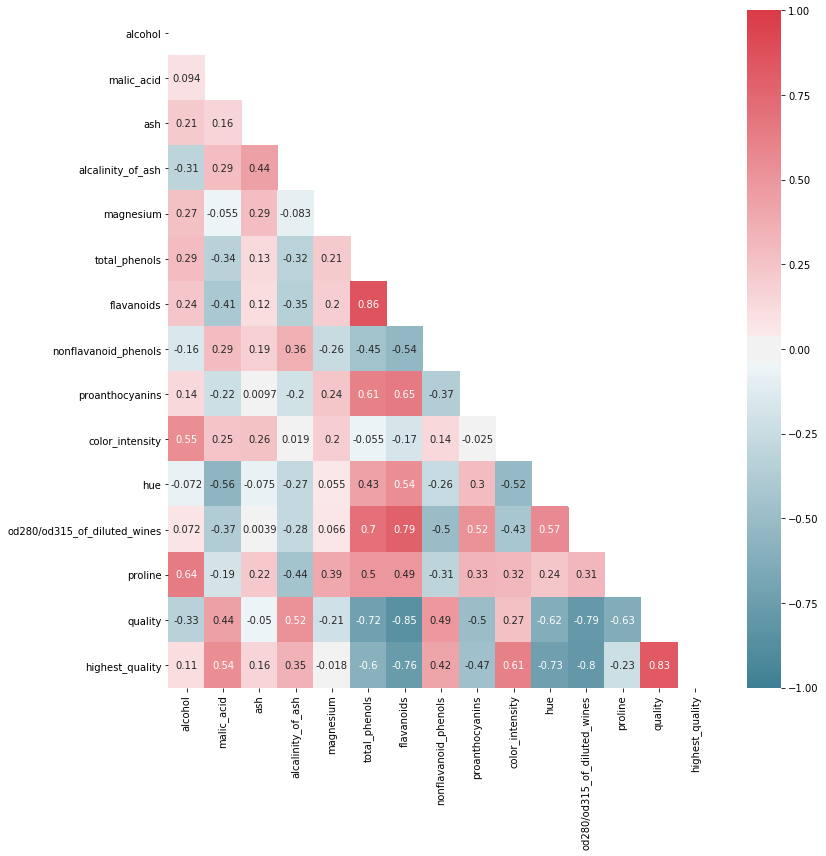

In [69]:
fig = plt.figure(figsize=(12, 12))
corr = wine_df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, annot=True, center=0, vmin=-1, vmax=1, mask=mask, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.tight_layout()
plt.show()

In [113]:
# sns.pairplot(wine_df, hue = "highest_quality", plot_kws=dict(alpha=0.8))
plt.show()

### Train and Test  sets

In [74]:
x_train, x_test, y_train, y_test = train_test_split(df, target,
                                                   test_size=0.25,
                                                   random_state=1,
                                                   stratify=target)

In [102]:
x_train, x_test, y_train, y_test = train_test_split(df, binary_target,
                                                   test_size=0.25,
                                                   random_state=1,
                                                   stratify=target)

In [103]:
x_train.shape

(133, 13)

In [104]:
x_test.shape

(45, 13)

In [105]:
y_train.shape

(133, 1)

### Black Box Model

#### Random Forest Model on Wine Data

In [106]:
rf_model = random_forest_model()
rf_model.fit(x_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=40, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [107]:
feature_importance(rf_model, x_train)

,importance
od280/od315_of_diluted_wines,0.317073
flavanoids,0.195122
hue,0.195122
malic_acid,0.073171
alcalinity_of_ash,0.073171
total_phenols,0.048780
color_intensity,0.048780
alcohol,0.024390
proanthocyanins,0.024390
ash,0.000000


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


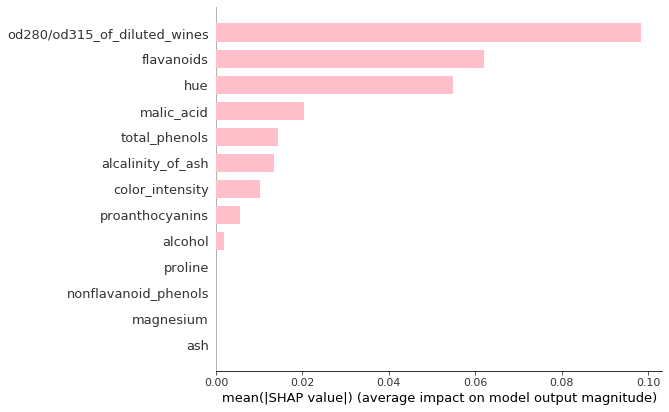

In [108]:
shap_features_bar_plot(rf_model, x_train, "pink")

In [109]:
n=4

In [111]:
# shap_values_importance_plot(rf_model, x_train, sample=3)

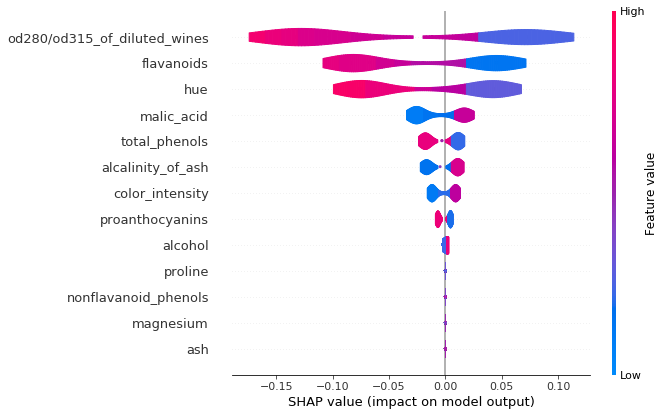

In [112]:
shap_violin_plot(rf_model, x_train)

In [ ]:
clf_results(x_train, x_test, y_train, y_test, rf_model)

In [ ]:
roc_curve_multi_class(df, target)

### SHAP Violin Plots for differnt wine targets

In [92]:
class_0_df = all_wine_df[all_wine_df["quality"] == 0]

In [93]:
class_1_df = all_wine_df[all_wine_df["quality"] == 1]

In [94]:
class_2_df = all_wine_df[all_wine_df["quality"] == 2]

### SHAP Violin Plot for Class 0 wine

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


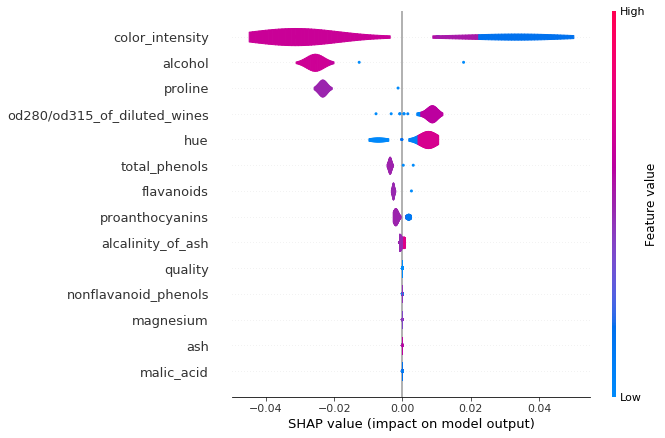

In [95]:
shap_violin_plot(rf_model, class_0_df)

### SHAP Violin Plot for Class 1 wine

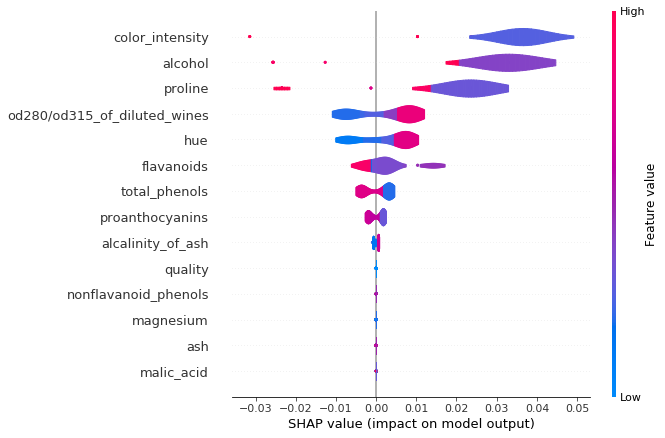

In [96]:
shap_violin_plot(rf_model, class_1_df)

### SHAP Violin Plot for Class 2 wine

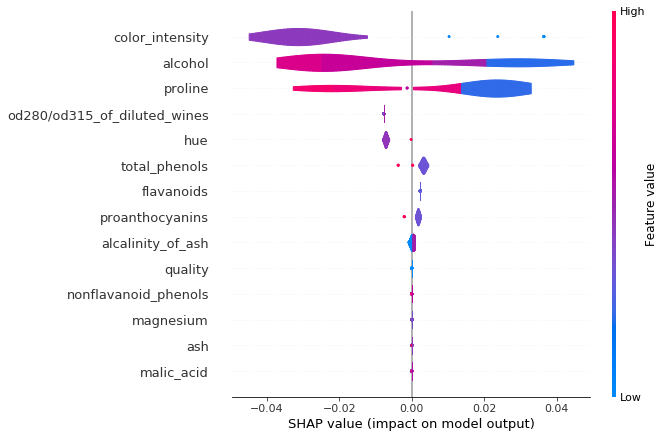

In [97]:
shap_violin_plot(rf_model, class_2_df)